# **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
data = pd.read_excel("/content/Online Retail.xlsx")

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **Data Prepocessing & EDA**

In [ ]:
print(data.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
# Bersihkan data
data = data.dropna(subset=["CustomerID"])
data = data[(data["Quantity"] > 0) & (data["UnitPrice"] > 0)]

In [ ]:
print(data.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [ ]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [ ]:
last_date = data["InvoiceDate"].max()

# **RFM Combination**

In [ ]:
rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (last_date - x.max()).days,
    "InvoiceNo": "nunique",
    "Quantity": "sum",
    "UnitPrice": "mean"
}).reset_index()

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency"
}, inplace=True)

# Hitung nilai-nilai tambahan
data["TotalValue"] = data["Quantity"] * data["UnitPrice"]
rfm["Monetary"] = data.groupby("CustomerID")["TotalValue"].sum().values
rfm["AvgPurchase"] = rfm["Monetary"] / rfm["Frequency"]
rfm["CLV"] = rfm["Frequency"] * rfm["AvgPurchase"]

In [ ]:
rfm1 = rfm[["CustomerID", "Recency", "Frequency", "Monetary"]].copy()

In [ ]:
rfm2 = rfm[["CustomerID", "Recency", "Frequency", "AvgPurchase"]].copy()

In [ ]:
rfm3 = rfm[["CustomerID", "Recency", "Frequency", "CLV"]].copy()

# **Function Pipeline**

In [ ]:
def scale_features(df, id_col):
    scaler = StandardScaler()
    features = df.drop(columns=[id_col])
    scaled = scaler.fit_transform(features)
    return pd.DataFrame(scaled, columns=features.columns, index=df[id_col])

def kmeans_cluster(df_scaled, k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_scaled)
    return clusters, kmeans

In [ ]:
def plot_elbow(df_scaled, title):
    wcss = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
    plt.figure(figsize=(6,4))
    plt.plot(range(2, 11), wcss, marker='o')
    plt.title(f"Elbow Method - {title}")
    plt.xlabel("Jumlah Cluster")
    plt.ylabel("WCSS")
    plt.show()

# **RFM Kombinasi 1**

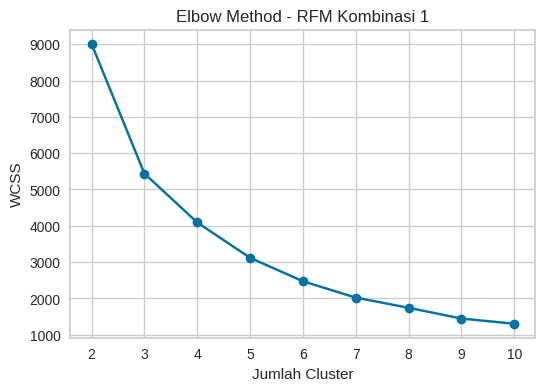

In [ ]:
rfm1_scaled = scale_features(rfm1, "CustomerID")
plot_elbow(rfm1_scaled, "RFM Kombinasi 1")

Silhouette Score for k=3: 0.59
Silhouette Score for k=4: 0.62
Silhouette Score for k=5: 0.62


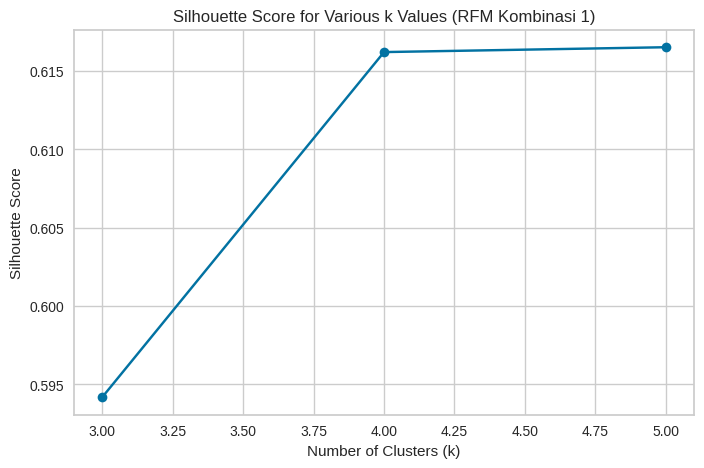

In [ ]:
silhouette_scores = []
for k in range(3,6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm1_scaled)
    score = silhouette_score(rfm1_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(range(3,6), silhouette_scores, marker='o')
plt.title('Silhouette Score for Various k Values (RFM Kombinasi 1)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
rfm1["Cluster"] = kmeans_cluster(rfm1_scaled, k=4)[0]

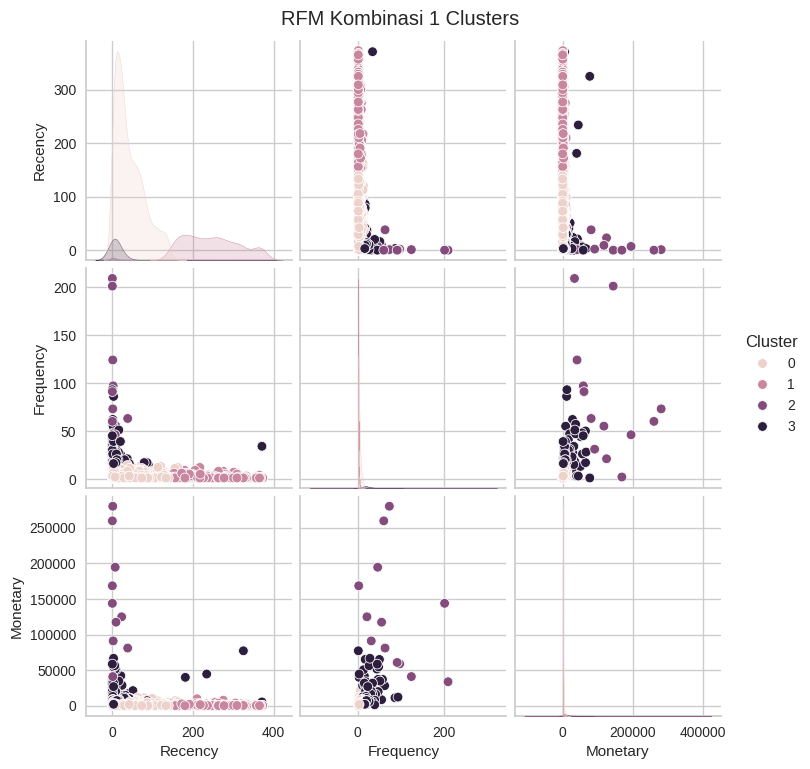

In [ ]:
sns.pairplot(rfm1.drop(columns=['CustomerID']), hue="Cluster", diag_kind="kde")
plt.suptitle("RFM Kombinasi 1 Clusters", y=1.02)
plt.show()

## **📊 Interpretasi Cluster RFM Kombinasi 1**

---

### **1. Cluster 2 — Titik Ungu tua**
**Label: *Champions / VIP* — "The Whales" / Top Spenders**

**Alasan Visual:**
- **Monetary (Tertinggi):** Pada plot Monetary (baris ke-3), titik hitam berada paling kanan dan terpisah jelas dari cluster lain.
- **Frequency (Tertinggi):** Pada plot Frequency (baris ke-2), titik hitam muncul di area paling atas.
- **Recency (Bagus):** Nilai Recency berada di sisi kiri (rendah), menunjukkan bahwa mereka baru saja bertransaksi.

**Karakteristik:**
- Pelanggan dengan **nilai terbesar**, **frekuensi tertinggi**, dan **paling aktif**.
- Jumlahnya sedikit (outlier), tetapi **kontribusi revenue sangat besar**.
- Termasuk kategori **prioritas utama** untuk dipertahankan.

---

### **2. Cluster 2 — Titik Hitam**
**Label: *Loyal Customers* — Pelanggan Setia**

**Alasan Visual:**
- **Frequency & Monetary (Tinggi):** Terletak tepat di bawah cluster VIP, tetapi secara konsisten lebih tinggi daripada cluster 0 dan 1.
- **Recency (Sangat Bagus):** Sebarannya rapat di nilai Recency sangat rendah (kiri), menandakan mereka aktif belanja akhir-akhir ini.

**Karakteristik:**
- Pelanggan yang **stabil, rutin, dan sangat dapat diandalkan**.
- Bukan big spender seperti VIP, namun menjadi **tulang punggung bisnis**.
- Sangat cocok untuk program loyalitas.

---

### **3. Cluster 1 — Titik Merah Muda/Mauve**
**Label: *Potential Loyalists* — Pelanggan Potensial**

**Alasan Visual:**
- **Recency (Bagus):** Banyak titik berada di sisi kiri Recency → mereka baru melakukan transaksi.
- **Frequency & Monetary (Rendah–Menengah):** Titik bergerombol di area bawah pada plot Frequency vs Monetary → transaksinya belum banyak dan nilai belanjanya kecil.

**Karakteristik:**
- Kemungkinan **pelanggan baru** atau **pelanggan aktif dengan transaksi kecil**.
- Memiliki potensi besar untuk di-upgrade menjadi *Loyal Customers* melalui program nurturing.
- Waktu terbaik untuk mulai melakukan **promosi ringan** atau **personalized offers**.

---

### **4. Cluster 0 — Titik Krem/Pucat**
**Label: *Hibernating / Low Value* — Pelanggan Pasif / At Risk**

**Alasan Visual:**
- **Recency (Buruk/Campuran):** Plot distribusinya memiliki "ekor panjang" ke kanan → banyak pelanggan yang sudah lama tidak belanja.
- **Frequency & Monetary (Sangat Rendah):** Titik menumpuk di nilai mendekati 0.

**Karakteristik:**
- Pelanggan **jarang belanja**, **nilai pembelian sangat kecil**, dan **banyak yang tidak aktif**.
- Menjadi segmen dengan nilai terendah.
- Cocok untuk strategi *win-back campaign* atau dibiarkan bila biaya retensi tidak sebanding dengan value.

---
## A. RFM Kombinasi 1 (Recency, Frequency, Monetary)
*Fokus: Keseimbangan umum antara aktivitas dan nilai uang.*

| Prioritas | Cluster ID | Label / Persona | Karakteristik Utama | Rekomendasi Tindakan |
| :--- | :--- | :--- | :--- | :--- |
| **1 (Utama)** | **2** | **Champions / VIP** | **High R, High F, High M.** Pelanggan elit dengan kontribusi terbesar. | **Retention Exclusive:** Berikan layanan prioritas, *personal assistance*, dan *reward* premium untuk menjaga mereka tetap senang. |
| **2 (Tinggi)** | **3** | **Loyal Customers** | **High F, High M.** Rutin berbelanja dan nilainya besar, meski tidak se-ekstrem VIP. | **Loyalty & Upselling:** Dorong masuk ke program loyalitas (poin) dan tawarkan produk pelengkap (*cross-sell*). |
| **3 (Sedang)** | **1** | **Potential Loyalists** | **Good R, Low-Mid F/M.** Pelanggan baru atau aktif dengan nilai keranjang kecil. | **Growth:** Berikan insentif (diskon/voucher) untuk pembelian berikutnya agar menjadi kebiasaan. |
| **4 (Rendah)** | **0** | **Hibernating** | **Bad R, Low F/M.** Sudah lama tidak aktif dan nilai historisnya rendah. | **Automation:** Kirim *campaign* reaktivasi otomatis. Jangan habiskan budget marketing besar di sini. |

# **RFM Kombinasi 2**

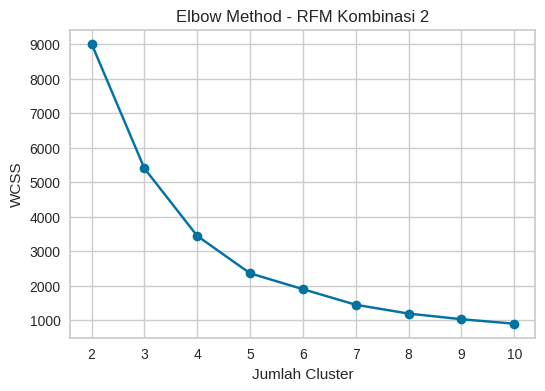

In [ ]:
rfm2_scaled = scale_features(rfm2, "CustomerID")
plot_elbow(rfm2_scaled, "RFM Kombinasi 2")

Silhouette Score for k=3: 0.57
Silhouette Score for k=4: 0.59
Silhouette Score for k=5: 0.60
Silhouette Score for k=6: 0.50


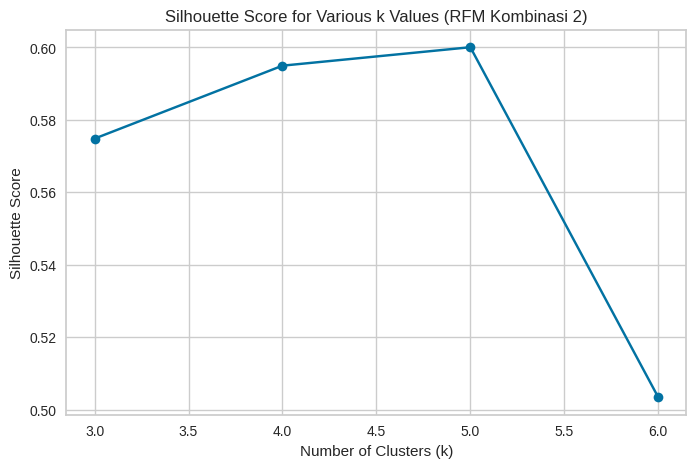

In [ ]:
silhouette_scores = []
for k in range(3,7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm2_scaled)
    score = silhouette_score(rfm2_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(range(3,7), silhouette_scores, marker='o')
plt.title('Silhouette Score for Various k Values (RFM Kombinasi 2)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
rfm2["Cluster"] = kmeans_cluster(rfm2_scaled, k=5)[0]

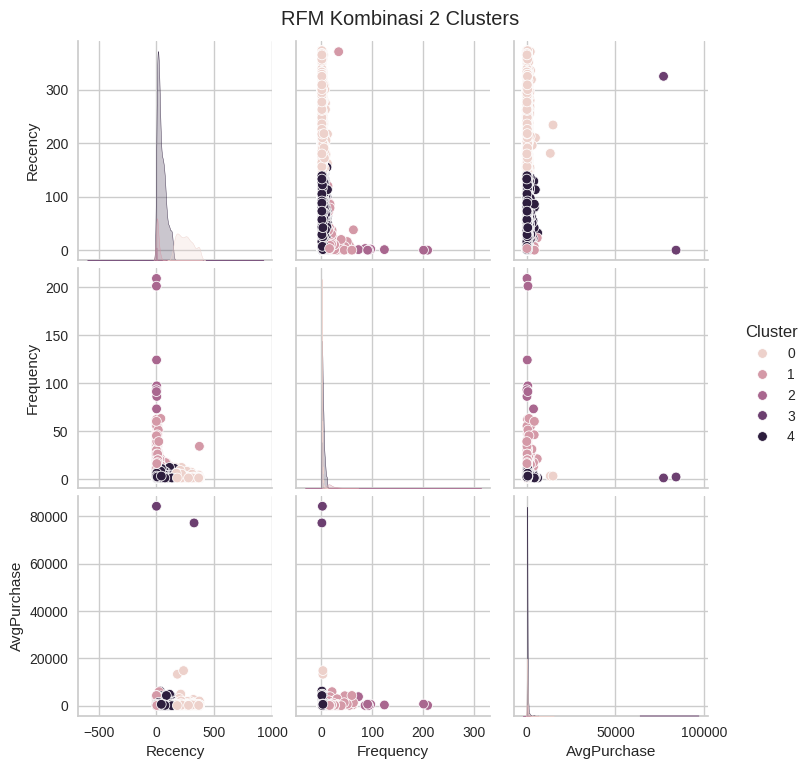

In [ ]:
sns.pairplot(rfm2.drop(columns=['CustomerID']), hue="Cluster", diag_kind="kde")
plt.suptitle("RFM Kombinasi 2 Clusters", y=1.02)
plt.show()

## 📊 Interpretasi Cluster (RFM Variasi: Recency – Frequency – AvgPurchase)

---

### **1. Cluster 3 — Titik Ungu Gelap / Hitam (Kanan Bawah)**
**Label: *The Whales / Big Spenders* — (Paus / Pembelanja Besar)**

**Alasan Visual:**
- **AvgPurchase (Sangat Tinggi):** Pada baris plot *AvgPurchase*, titik cluster ini menjadi outlier ekstrem (nilai > 80.000) dan terpisah jauh di sisi kanan.
- **Frequency (Rendah–Sedang):** Tidak seaktif Cluster 2 dalam frekuensi. Namun, **nilai belanja per transaksi sangat besar**.

**Karakteristik:**
- Kelompok “**Sultan**”.
- Jarang belanja, tapi sekali belanja langsung **memborong barang mahal**.
- Memberikan kontribusi pendapatan besar meski jumlahnya sedikit.

**Strategi:**
- Perlakuan VIP & personal.
- Produk eksklusif, limited edition.
- Early access produk baru.

---

### **2. Cluster 2 — Titik Ungu Tua / Magenta**
**Label: *Loyalists / High Frequency* — (Pelanggan Setia)**

**Alasan Visual:**
- **Frequency (Tertinggi):** Titik cluster ini naik paling tinggi di sumbu Y (bahkan mencapai >100–200).
- **Recency (Sangat Bagus):** Menempel di kiri sumbu Recency → sangat aktif dan sering kembali.

**Karakteristik:**
- Pelanggan yang "hobi" belanja.
- Pembelian rata-rata tidak sebesar Whales, tetapi merekalah **penggerak traffic & transaksi harian**.

**Strategi:**
- Program membership.
- Sistem poin & reward.
- Cross-selling untuk menaikkan nilai keranjang belanja.

---

### **3. Cluster 4 — Titik Hitam Pekat / Biru Tua (Kiri Bawah)**
**Label: *New Customers / Fresh Leads* — (Pelanggan Baru)**

**Alasan Visual:**
- **Recency (Terbaik):** Sangat rapat di angka 0 → baru saja bertransaksi.
- **Frequency & AvgPurchase (Rendah):** Masih bergerombol di area bawah (transaksi sedikit & nilai belanja rendah).

**Karakteristik:**
- Pelanggan baru (transaksi 1–2 kali).
- Potensi masih belum terlihat: bisa menjadi loyal atau hilang.

**Strategi:**
- Onboarding yang ramah.
- Diskon untuk pembelian berikutnya.
- Edukasi produk agar mereka merasa nyaman.

---

### **4. Cluster 1 — Titik Merah Muda / Pink**
**Label: *Occasional / Casual Shoppers* — (Pelanggan Biasa)**

**Alasan Visual:**
- **Recency (Menengah):** Tidak terlalu baru namun juga tidak lama hilang.
- **Frequency & AvgPurchase (Rendah–Menengah):** Menumpuk di area bawah tetapi lebih tersebar daripada cluster baru.

**Karakteristik:**
- Segmen mass market.
- Belanja sesekali dengan nilai standar.
- Tidak terlalu loyal tetapi tetap aktif.

**Strategi:**
- Promo musiman (seasonal promo).
- Bundling produk.
- Upselling ringan.

---

### **5. Cluster 0 — Titik Krem / Pucat**
**Label: *Lost / Hibernating* — (Pelanggan Hilang / Tidur)**

**Alasan Visual:**
- **Recency (Terburuk):** Distribusi sangat panjang ke kanan (>200 hari).
- **Activity (Hampir Nol):** Frequency dan AvgPurchase sangat rendah (menumpuk di dasar grafik).

**Karakteristik:**
- Mantan pelanggan yang tidak pernah kembali.
- Kemungkinan besar berpindah ke kompetitor atau sudah tidak membutuhkan produk.

**Strategi:**
- Win-back campaign (“Kami rindu Anda” + voucher).
- Atau abaikan jika biaya retensi tidak sebanding dengan value.

---
## B. RFM Kombinasi 2 (Recency, Frequency, AvgPurchase)
*Fokus: Memisahkan pelanggan berdasarkan nilai rata-rata per transaksi (Big Spenders vs Frequent Shoppers).*

| Prioritas | Cluster ID | Label / Persona | Karakteristik Utama | Rekomendasi Tindakan |
| :--- | :--- | :--- | :--- | :--- |
| **1 (Kritis)** | **3** | **The Whales** | **Extreme AvgPurchase.** Jarang muncul, tapi sekali belanja nilainya fantastis. | **VIP Treatment:** Tawarkan produk *high-end* atau *limited edition*. Perlakukan sebagai investor VIP. |
| **1 (Kritis)** | **2** | **Loyalists** | **Highest Frequency.** Paling sering berkunjung/transaksi. Motor penggerak trafik harian. | **Volume Driver:** Pastikan stok barang favorit mereka selalu ada. Berikan *reward* berbasis frekuensi (misal: "Beli 10 Gratis 1"). |
| **2 (Potensi)** | **4** | **New Customers** | **Best Recency (0).** User yang benar-benar baru bergabung (belum ada *track record* F/M). | **Onboarding:** Berikan pengalaman pertama yang sempurna (*first impression*) dan panduan produk. |
| **3 (Standar)** | **1** | **Casual Shoppers** | **Mid R, Low-Mid Activity.** Mayoritas pelanggan dengan perilaku standar. | **Seasonal Promo:** Tawarkan promo saat *event* tertentu (lebaran/natal) untuk menjaga aktivitas. |
| **4 (Rendah)** | **0** | **Lost / Churned** | **Worst Recency.** Sudah pergi/pindah ke kompetitor. | **Ignore/Low Cost:** Fokuskan sumber daya pada cluster lain yang lebih menjanjikan (Cluster 2, 3, 4). |


# **RFM Kombinasi 3**

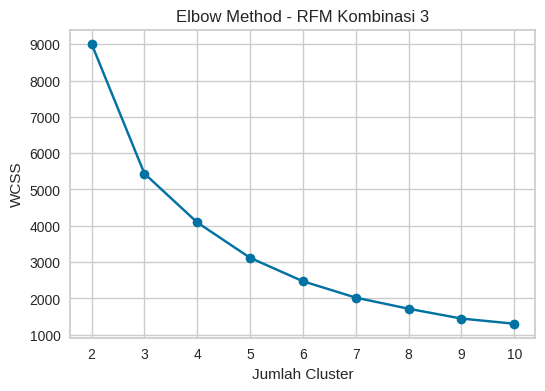

In [ ]:
rfm3_scaled = scale_features(rfm3, "CustomerID")
plot_elbow(rfm3_scaled, "RFM Kombinasi 3")

Silhouette Score for k=3: 0.5942
Silhouette Score for k=4: 0.6162
Silhouette Score for k=5: 0.6165


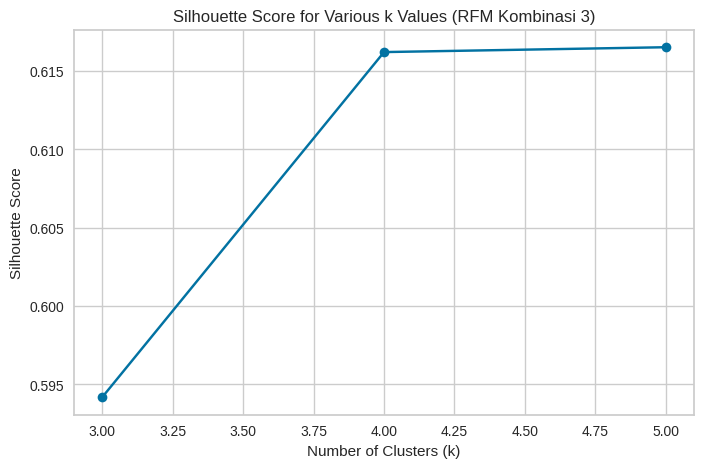

In [ ]:
silhouette_scores = []
for k in range(3,6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm3_scaled)
    score = silhouette_score(rfm3_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(3,6), silhouette_scores, marker='o')
plt.title('Silhouette Score for Various k Values (RFM Kombinasi 3)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
rfm3["Cluster"] = kmeans_cluster(rfm3_scaled, k=5)[0]

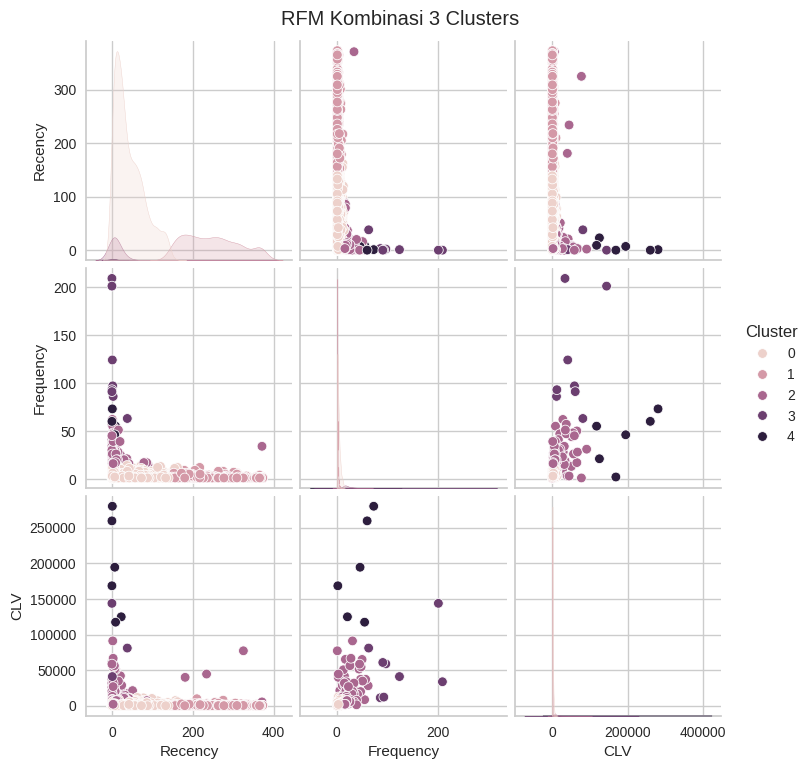

In [ ]:
sns.pairplot(rfm3.drop(columns=['CustomerID']), hue="Cluster", diag_kind="kde")
plt.suptitle("RFM Kombinasi 3 Clusters", y=1.02)
plt.show()

## 📊 **Interpretasi Cluster RFM (Recency, Frequency, CLV)**

Berdasarkan visualisasi *Pairplot* dengan atribut CLV, berikut adalah profil untuk ke-5 cluster yang terbentuk, diurutkan dari nilai bisnis tertinggi ke terendah:

### 1. Cluster 4 (Titik Hitam Pekat)
**Label:** **"The Kings / Top VIP"**
* **Alasan Visual:**
    * **CLV & Frequency (Tertinggi):** Merupakan *outlier* ekstrem di bagian paling atas (Frequency) dan paling kanan (CLV). Jauh memisahkan diri dari kelompok lain.
    * **Recency (Sangat Bagus):** Berada di sisi kiri (nilai 0), menandakan mereka baru saja bertransaksi.
* **Karakteristik:** Pelanggan dengan nilai seumur hidup (CLV) tertinggi. Mereka sangat sering belanja dan total uang yang dikeluarkan sangat masif. Jumlahnya sangat sedikit tapi sangat vital.
* **Strategi:** *Hyper-personalization*, akses eksklusif ke manajemen/produk baru, jangan sampai mereka kecewa sedikitpun.

---

### 2. Cluster 3 (Titik Ungu Tua)
**Label:** **"Loyal Whales"** (Pelanggan Loyal Bernilai Tinggi)
* **Alasan Visual:**
    * **High Value:** Berada tepat di bawah Cluster 4. Memiliki Frequency dan CLV yang tinggi (di atas rata-rata populasi umum), meskipun tidak se-ekstrem Cluster 4.
    * **Recency (Bagus):** Konsisten berada di area Recency rendah.
* **Karakteristik:** Pelanggan setia yang sudah terbukti memberikan keuntungan besar secara jangka panjang.
* **Strategi:** *Retention* agresif, berikan *reward* poin yang menarik agar tidak pindah ke kompetitor.

---

### 3. Cluster 2 (Titik Ungu Sedang/Magenta)
**Label:** **"Potential Loyalists"** (Bintang Baru)
* **Alasan Visual:**
    * **Mid-Range Activity:** Berada di tengah-tengah grafik Frequency dan CLV. Lebih tinggi dari pelanggan biasa (Cluster 0/1) tapi belum mencapai level "Whales".
    * **Recency (Bagus):** Masih aktif bertransaksi (Recency rendah).
* **Karakteristik:** Pelanggan yang aktif dan mulai menunjukkan kebiasaan belanja yang baik. Punya potensi besar untuk naik kelas menjadi VIP.
* **Strategi:** Tawarkan *membership* atau rekomendasi produk (*upselling*) untuk menaikkan nilai CLV mereka.

---

### 4. Cluster 1 (Titik Merah Muda/Pink)
**Label:** **"New / Low Spenders"** (Pelanggan Baru atau Hemat)
* **Alasan Visual:**
    * **Recency (Bagus - Rendah):** Perhatikan sebarannya menumpuk di angka Recency rendah (mirip cluster unggulan).
    * **Low CLV & Freq:** Namun, titiknya bergerombol di pojok bawah (nilai transaksi dan frekuensi masih minim).
* **Karakteristik:** Kemungkinan besar pelanggan baru yang baru 1-2 kali transaksi, atau pelanggan aktif yang hanya membeli barang murah.
* **Strategi:** Edukasi produk, diskon pembelian kedua, bangun *engagement*.

---

### 5. Cluster 0 (Titik Krem/Pucat)
**Label:** **"Hibernating / Churned"** (Berisiko Hilang)
* **Alasan Visual:**
    * **Recency (Terburuk):** Lihat plot distribusi di pojok kiri atas. Warna krem memiliki "ekor" panjang ke kanan, yang berarti mayoritas anggotanya memiliki nilai Recency tinggi (sudah lama tidak aktif).
    * **Low Value:** Nilai CLV dan Frequency sangat rendah (menumpuk di nol).
* **Karakteristik:** Pelanggan yang sudah lama menghilang dan kontribusi nilainya rendah.
* **Strategi:** Abaikan jika biaya marketing tinggi, atau kirimkan email otomatisasi standar untuk mencoba memanggil kembali.

---

### Tabel Ringkasan Strategis

| Cluster | Label | Value (CLV) | Frequency | Recency | Prioritas |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **4** | **Top VIP** | Very High | Very High | Low (Active) | **Critical** |
| **3** | **Loyal Whales** | High | High | Low (Active) | High |
| **2** | **Potential** | Medium | Medium | Low (Active) | Medium |
| **1** | **New/Small** | Low | Low | Low (Active) | Standard |
| **0** | **Hibernating** | Low | Low | High (Inactive) | Low |

In [ ]:
def summarize_cluster(df, value_cols):
    return df.groupby("Cluster")[value_cols].mean().round(2)

summary1 = summarize_cluster(rfm1, ["Recency", "Frequency", "Monetary"])
summary2 = summarize_cluster(rfm2, ["Recency", "Frequency", "AvgPurchase"])
summary3 = summarize_cluster(rfm3, ["Recency", "Frequency", "CLV"])

print("=== Kombinasi 1 ===")
print(summary1)
print("\n=== Kombinasi 2 ===")
print(summary2)
print("\n=== Kombinasi 3 ===")
print(summary3)


=== Kombinasi 1 ===
         Recency  Frequency   Monetary
Cluster                               
0          42.70       3.68    1359.05
1         247.08       1.55     480.62
2           6.38      82.54  127338.31
3          14.50      22.33   12709.09

=== Kombinasi 2 ===
         Recency  Frequency  AvgPurchase
Cluster                                 
0         247.42       1.57       341.07
1          11.79      20.31       553.21
2           0.88     121.75       822.62
3         162.50       1.50     80709.92
4          43.46       3.47       380.13

=== Kombinasi 3 ===
         Recency  Frequency        CLV
Cluster                               
0          42.95       3.65    1339.07
1         247.56       1.55     478.11
2          14.67      21.29   12831.74
3           5.50     120.50   55312.69
4           6.67      42.83  190863.46


# Visualisasi

Bar chart - distribusi pelanggan per cluster

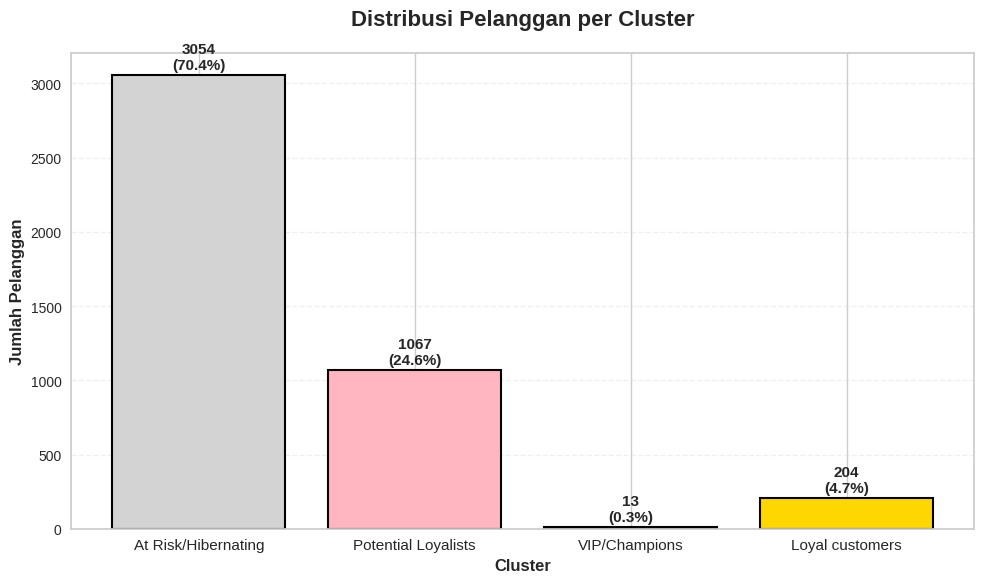

SUMMARY DISTRIBUSI PELANGGAN
At Risk/Hibernating: 3054 pelanggan (70.40%)
Potential Loyalists: 1067 pelanggan (24.60%)
VIP/Champions: 13 pelanggan (0.30%)
Loyal customers: 204 pelanggan (4.70%)

Total Pelanggan: 4338


In [ ]:
cluster_counts = rfm1['Cluster'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values,
               color=['#D3D3D3', '#FFB6C1', '#9370DB', '#FFD700'],
               edgecolor='black', linewidth=1.5)

for i, (index, value) in enumerate(cluster_counts.items()):
    percentage = (value / cluster_counts.sum()) * 100
    plt.text(index, value + 20, f'{value}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

cluster_labels = {
    0: 'At Risk/Hibernating',
    1: 'Potential Loyalists',
    2: 'VIP/Champions',
    3: 'Loyal customers'
}

plt.title('Distribusi Pelanggan per Cluster', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Pelanggan', fontsize=12, fontweight='bold')
plt.xticks(cluster_counts.index,
           [cluster_labels[i] for i in cluster_counts.index],
           fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Tampilkan summary statistik
print("=" * 50)
print("SUMMARY DISTRIBUSI PELANGGAN")
print("=" * 50)
for cluster_id in sorted(cluster_counts.index):
    count = cluster_counts[cluster_id]
    pct = (count / cluster_counts.sum()) * 100
    print(f"{cluster_labels[cluster_id]}: {count} pelanggan ({pct:.2f}%)")
print(f"\nTotal Pelanggan: {cluster_counts.sum()}")

Stacked Bar - Reveue contribution per cluster

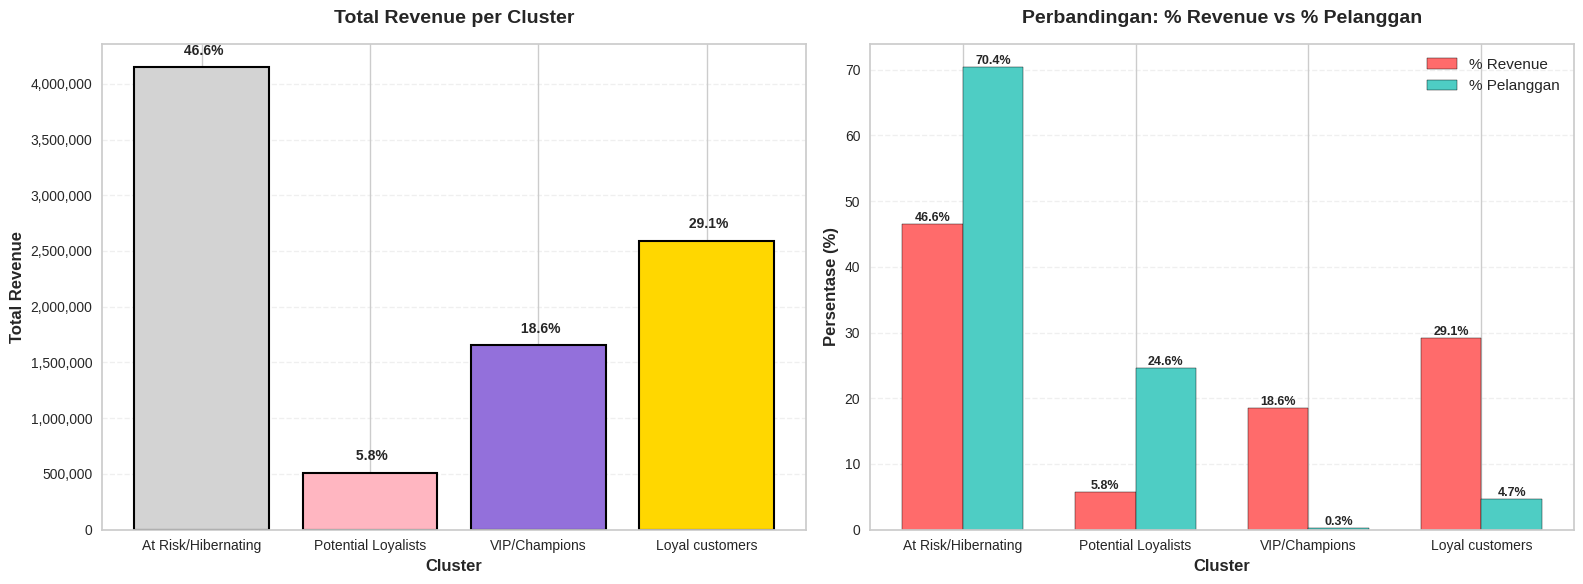


REVENUE CONTRIBUTION ANALYSIS
           Monetary  Customer_Count  Revenue_Pct  Customer_Pct
Cluster                                                       
0        4150536.51            3054        46.58          70.4
1         512818.85            1067         5.75          24.6
2        1655398.08              13        18.58           0.3
3        2592654.46             204        29.09           4.7

 KEY INSIGHTS:

Cluster 0 → At Risk/Hibernating:
  - 70.4% pelanggan → 46.6% revenue

Cluster 1 → Potential Loyalists:
  - 24.6% pelanggan → 5.8% revenue
  - LOW VALUE: Kontribusi hanya 0.2x dari jumlah pelanggan

Cluster 2 → VIP/Champions:
  - 0.3% pelanggan → 18.6% revenue
  - HIGH VALUE: Kontribusi 62.0x lebih besar dari jumlah pelanggan!

Cluster 3 → Loyal customers:
  - 4.7% pelanggan → 29.1% revenue
  - HIGH VALUE: Kontribusi 6.2x lebih besar dari jumlah pelanggan!


In [ ]:
revenue_analysis = rfm1.groupby('Cluster').agg({
    'Monetary': 'sum',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Customer_Count'})

revenue_analysis['Revenue_Pct'] = (revenue_analysis['Monetary'] /
                                    revenue_analysis['Monetary'].sum()) * 100
revenue_analysis['Customer_Pct'] = (revenue_analysis['Customer_Count'] /
                                     revenue_analysis['Customer_Count'].sum()) * 100


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cluster_labels = {
    0: 'At Risk/Hibernating',
    1: 'Potential Loyalists',
    2: 'VIP/Champions',
    3: 'Loyal customers'
}

# ===== PLOT 1: Total Revenue per Cluster =====
colors = ['#D3D3D3', '#FFB6C1', '#9370DB', '#FFD700']
bars1 = ax1.bar(revenue_analysis.index,
                revenue_analysis['Monetary'],
                color=colors,
                edgecolor='black',
                linewidth=1.5)

for i, (idx, row) in enumerate(revenue_analysis.iterrows()):
    ax1.text(idx, row['Monetary'] + (revenue_analysis['Monetary'].max() * 0.02),
             f' {row["Revenue_Pct"]:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_title('Total Revenue per Cluster', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Revenue', fontsize=12, fontweight='bold')
ax1.set_xticks(revenue_analysis.index)
ax1.set_xticklabels([cluster_labels[i] for i in revenue_analysis.index])
ax1.grid(axis='y', alpha=0.3, linestyle='--')

ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# ===== PLOT 2: Stacked Percentage Comparison =====
x = np.arange(len(revenue_analysis))
width = 0.35

bars2 = ax2.bar(x - width/2, revenue_analysis['Revenue_Pct'], width,
                label='% Revenue', color='#FF6B6B', edgecolor='black')
bars3 = ax2.bar(x + width/2, revenue_analysis['Customer_Pct'], width,
                label='% Pelanggan', color='#4ECDC4', edgecolor='black')

for bars in [bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_title('Perbandingan: % Revenue vs % Pelanggan',
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax2.set_ylabel('Persentase (%)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([cluster_labels[i] for i in revenue_analysis.index])
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Tampilkan summary table
print("\n" + "=" * 80)
print("REVENUE CONTRIBUTION ANALYSIS")
print("=" * 80)
print(revenue_analysis.round(2))
print("\n KEY INSIGHTS:")
for (cluster_id, label), (_, row) in zip(cluster_labels.items(), revenue_analysis.iterrows()):
    print(f"\nCluster {cluster_id} → {label}:")
    print(f"  - {row['Customer_Pct']:.1f}% pelanggan → {row['Revenue_Pct']:.1f}% revenue")
    ratio = row['Revenue_Pct'] / row['Customer_Pct']
    if ratio > 1.5:
        print(f"  - HIGH VALUE: Kontribusi {ratio:.1f}x lebih besar dari jumlah pelanggan!")
    elif ratio < 0.5:
        print(f"  - LOW VALUE: Kontribusi hanya {ratio:.1f}x dari jumlah pelanggan")

Scatter plot - Clustering quality

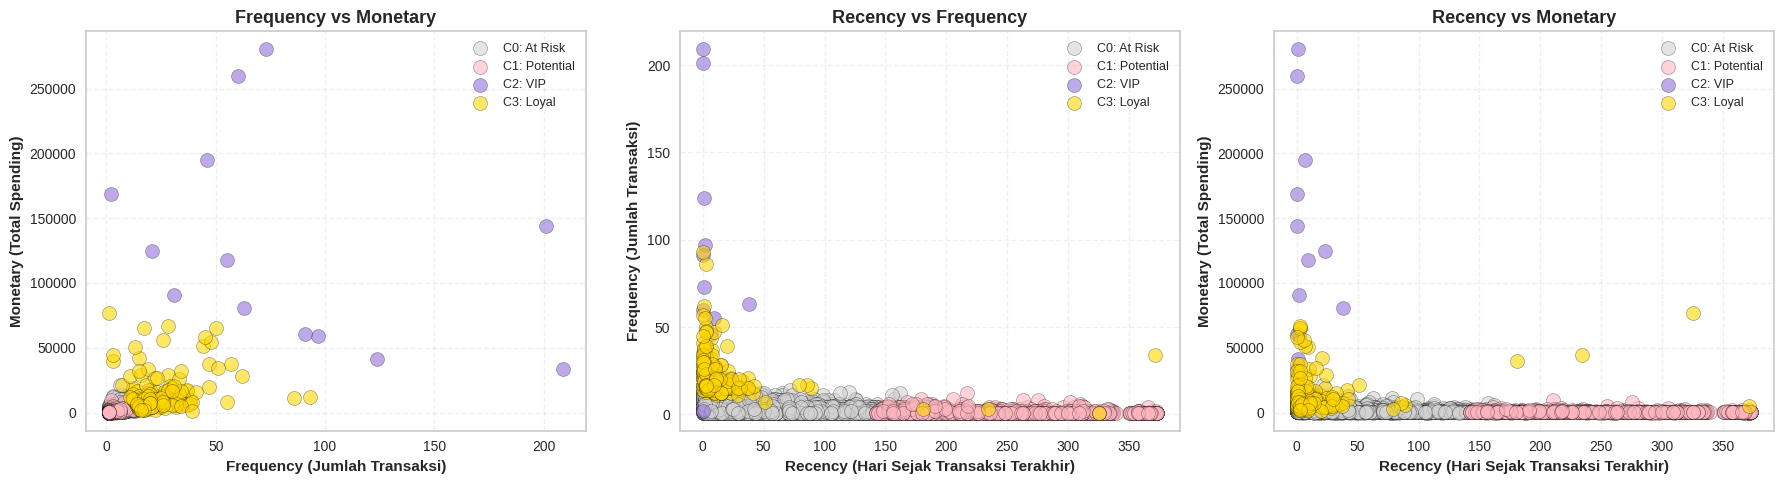

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors_map = {0: '#D3D3D3', 1: '#FFB6C1', 2: '#9370DB', 3: '#FFD700'}
cluster_names = {0: 'At Risk', 1: 'Potential', 2: 'VIP', 3: 'Loyal'}

# ===== PLOT 1: Frequency vs Monetary =====
for cluster in sorted(rfm1['Cluster'].unique()):
    cluster_data = rfm1[rfm1['Cluster'] == cluster]
    axes[0].scatter(cluster_data['Frequency'],
                    cluster_data['Monetary'],
                    c=colors_map[cluster],
                    label=f'C{cluster}: {cluster_names[cluster]}',
                    alpha=0.6,
                    edgecolors='black',
                    s=100)

axes[0].set_xlabel('Frequency (Jumlah Transaksi)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Monetary (Total Spending)', fontsize=11, fontweight='bold')
axes[0].set_title('Frequency vs Monetary', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

# ===== PLOT 2: Recency vs Frequency =====
for cluster in sorted(rfm1['Cluster'].unique()):
    cluster_data = rfm1[rfm1['Cluster'] == cluster]
    axes[1].scatter(cluster_data['Recency'],
                    cluster_data['Frequency'],
                    c=colors_map[cluster],
                    label=f'C{cluster}: {cluster_names[cluster]}',
                    alpha=0.6,
                    edgecolors='black',
                    s=100)

axes[1].set_xlabel('Recency (Hari Sejak Transaksi Terakhir)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency (Jumlah Transaksi)', fontsize=11, fontweight='bold')
axes[1].set_title('Recency vs Frequency', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(alpha=0.3, linestyle='--')

# ===== PLOT 3: Recency vs Monetary =====
for cluster in sorted(rfm1['Cluster'].unique()):
    cluster_data = rfm1[rfm1['Cluster'] == cluster]
    axes[2].scatter(cluster_data['Recency'],
                    cluster_data['Monetary'],
                    c=colors_map[cluster],
                    label=f'C{cluster}: {cluster_names[cluster]}',
                    alpha=0.6,
                    edgecolors='black',
                    s=100)

axes[2].set_xlabel('Recency (Hari Sejak Transaksi Terakhir)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Monetary (Total Spending)', fontsize=11, fontweight='bold')
axes[2].set_title('Recency vs Monetary', fontsize=13, fontweight='bold')
axes[2].legend(loc='upper right', fontsize=9)
axes[2].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()